In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import emcee
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
emcee_outputdir = "/fred/oz004/msinha/sage_mcmc_output"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_z=0.0"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_z_0.0_nwalkers_1000"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_0.0_nwalkers_1000"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_6.0_nwalkers_1000"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_0.0_nwalkers_1000_with_restarts_no_resumes"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_0.0_nwalkers_1000"
chain_name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_4.0_nwalkers_1000"
#name = "SfrEfficiency_ReIncorporationFactor_FeedbackReheatingEpsilon_RadioModeEfficiency_z_0.0_nwalkers_1000"
chain_filename = f"{emcee_outputdir}/sage_emcee_{chain_name}.hdf5"


In [3]:
def get_labels_from_chain_name(chain_name):
    labels = []
    for label in chain_name.split('_'):
        if label.startswith('z'): break
        labels.append(label)
    print(f"{labels =}")
    return labels


In [4]:
def get_name_from_chain_name(chain_name):
    split_pattern = '_nwalkers_'
    name, suffix = chain_name.rsplit(split_pattern)
    name += split_pattern
    name += suffix.split('_')[0]
    return name

In [5]:
def get_tau_from_reader(reader):
    tau = 0.0
    try:
        tau = reader.get_autocorr_time()
    except:
        print("Error getting auto-correlation time")
        tau = 1000.0
        pass

    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    print(f"{burnin = } {thin = } {tau = }")
    return tau, burnin, thin

In [6]:
def plot_walkers(reader, labels):
    import matplotlib.pyplot as plt
    _, burnin, thin = get_tau_from_reader(reader)
    chain = reader.get_chain(discard=burnin, thin=thin)
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(chain[:, :, i], "k", alpha=0.01)
        ax.set_xlim(0, len(chain))
        ax.set_ylabel(labels[i], fontsize=20)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("iteration", fontsize=20);

In [7]:
def sage_param_to_axis_labels(params):
    param_mapping = {'SfrEfficiency': r"$\epsilon_{sfr}$",
                     'ReIncorporationFactor': r"$f_{reinc}$",
                     'FeedbackReheatingEpsilon': r"$\eta_{reheat}$",
                     'RadioModeEfficiency': r"$f_{radio}$"
                     }

    return [param_mapping[k] if k in param_mapping.keys() else k for k in params]

In [8]:
def get_sage_axis_limits(param):
    param_mapping = {'SfrEfficiency': [0.0, 0.1],
                     'ReIncorporationFactor': [0.0, 0.5],
                     'FeedbackReheatingEpsilon': [0.0, 0.5],
                     'RadioModeEfficiency': [0.0, 0.5],
                     }

    return param_mapping[param]

In [9]:
def plot_contours_and_ci(reader, labels, **kwargs):
    import corner
    import numpy as np
    from IPython.display import display, Math

    _, burnin, thin = get_tau_from_reader(reader)
    # burnin = 300
    # thin = 10
    titles = sage_param_to_axis_labels(labels)
    # print(f"{labels = }")
    # print(f"{titles = }")
    flat_chain = reader.get_chain(discard=burnin, flat=True, thin=thin)

    # flat_chain = reader.get_chain(flat=True)
    fig = corner.corner(flat_chain, titles=titles, **kwargs)
    # fig.tight_layout()

    ndim = len(labels)
    for i in range(ndim):
        mcmc = np.percentile(flat_chain[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))


In [10]:
def generate_plots(chain_name):
    labels = get_labels_from_chain_name(chain_name)
    name = get_name_from_chain_name(chain_name)

    reader = emcee.backends.HDFBackend(chain_filename, name=name, read_only=True)

    tau = reader.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    # chain = reader.get_chain(discard=burnin, thin=thin)
    #flatchain = reader.get_chain(discard=burnin, flat=True, thin=thin)
    #log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
    #log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

    print(f"{burnin = }")
    print(f"{thin =}")

    # plot_walkers(reader, labels)
    plot_contours_and_ci(reader, labels)
# print("flat chain shape: {0}".format(chain.shape))
# print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

labels =['SfrEfficiency', 'ReIncorporationFactor', 'FeedbackReheatingEpsilon', 'RadioModeEfficiency']
burnin = 268
thin =37
burnin = 268 thin = 37 tau = array([134.30770383,  74.53902332, 101.94636902, 102.09943427])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

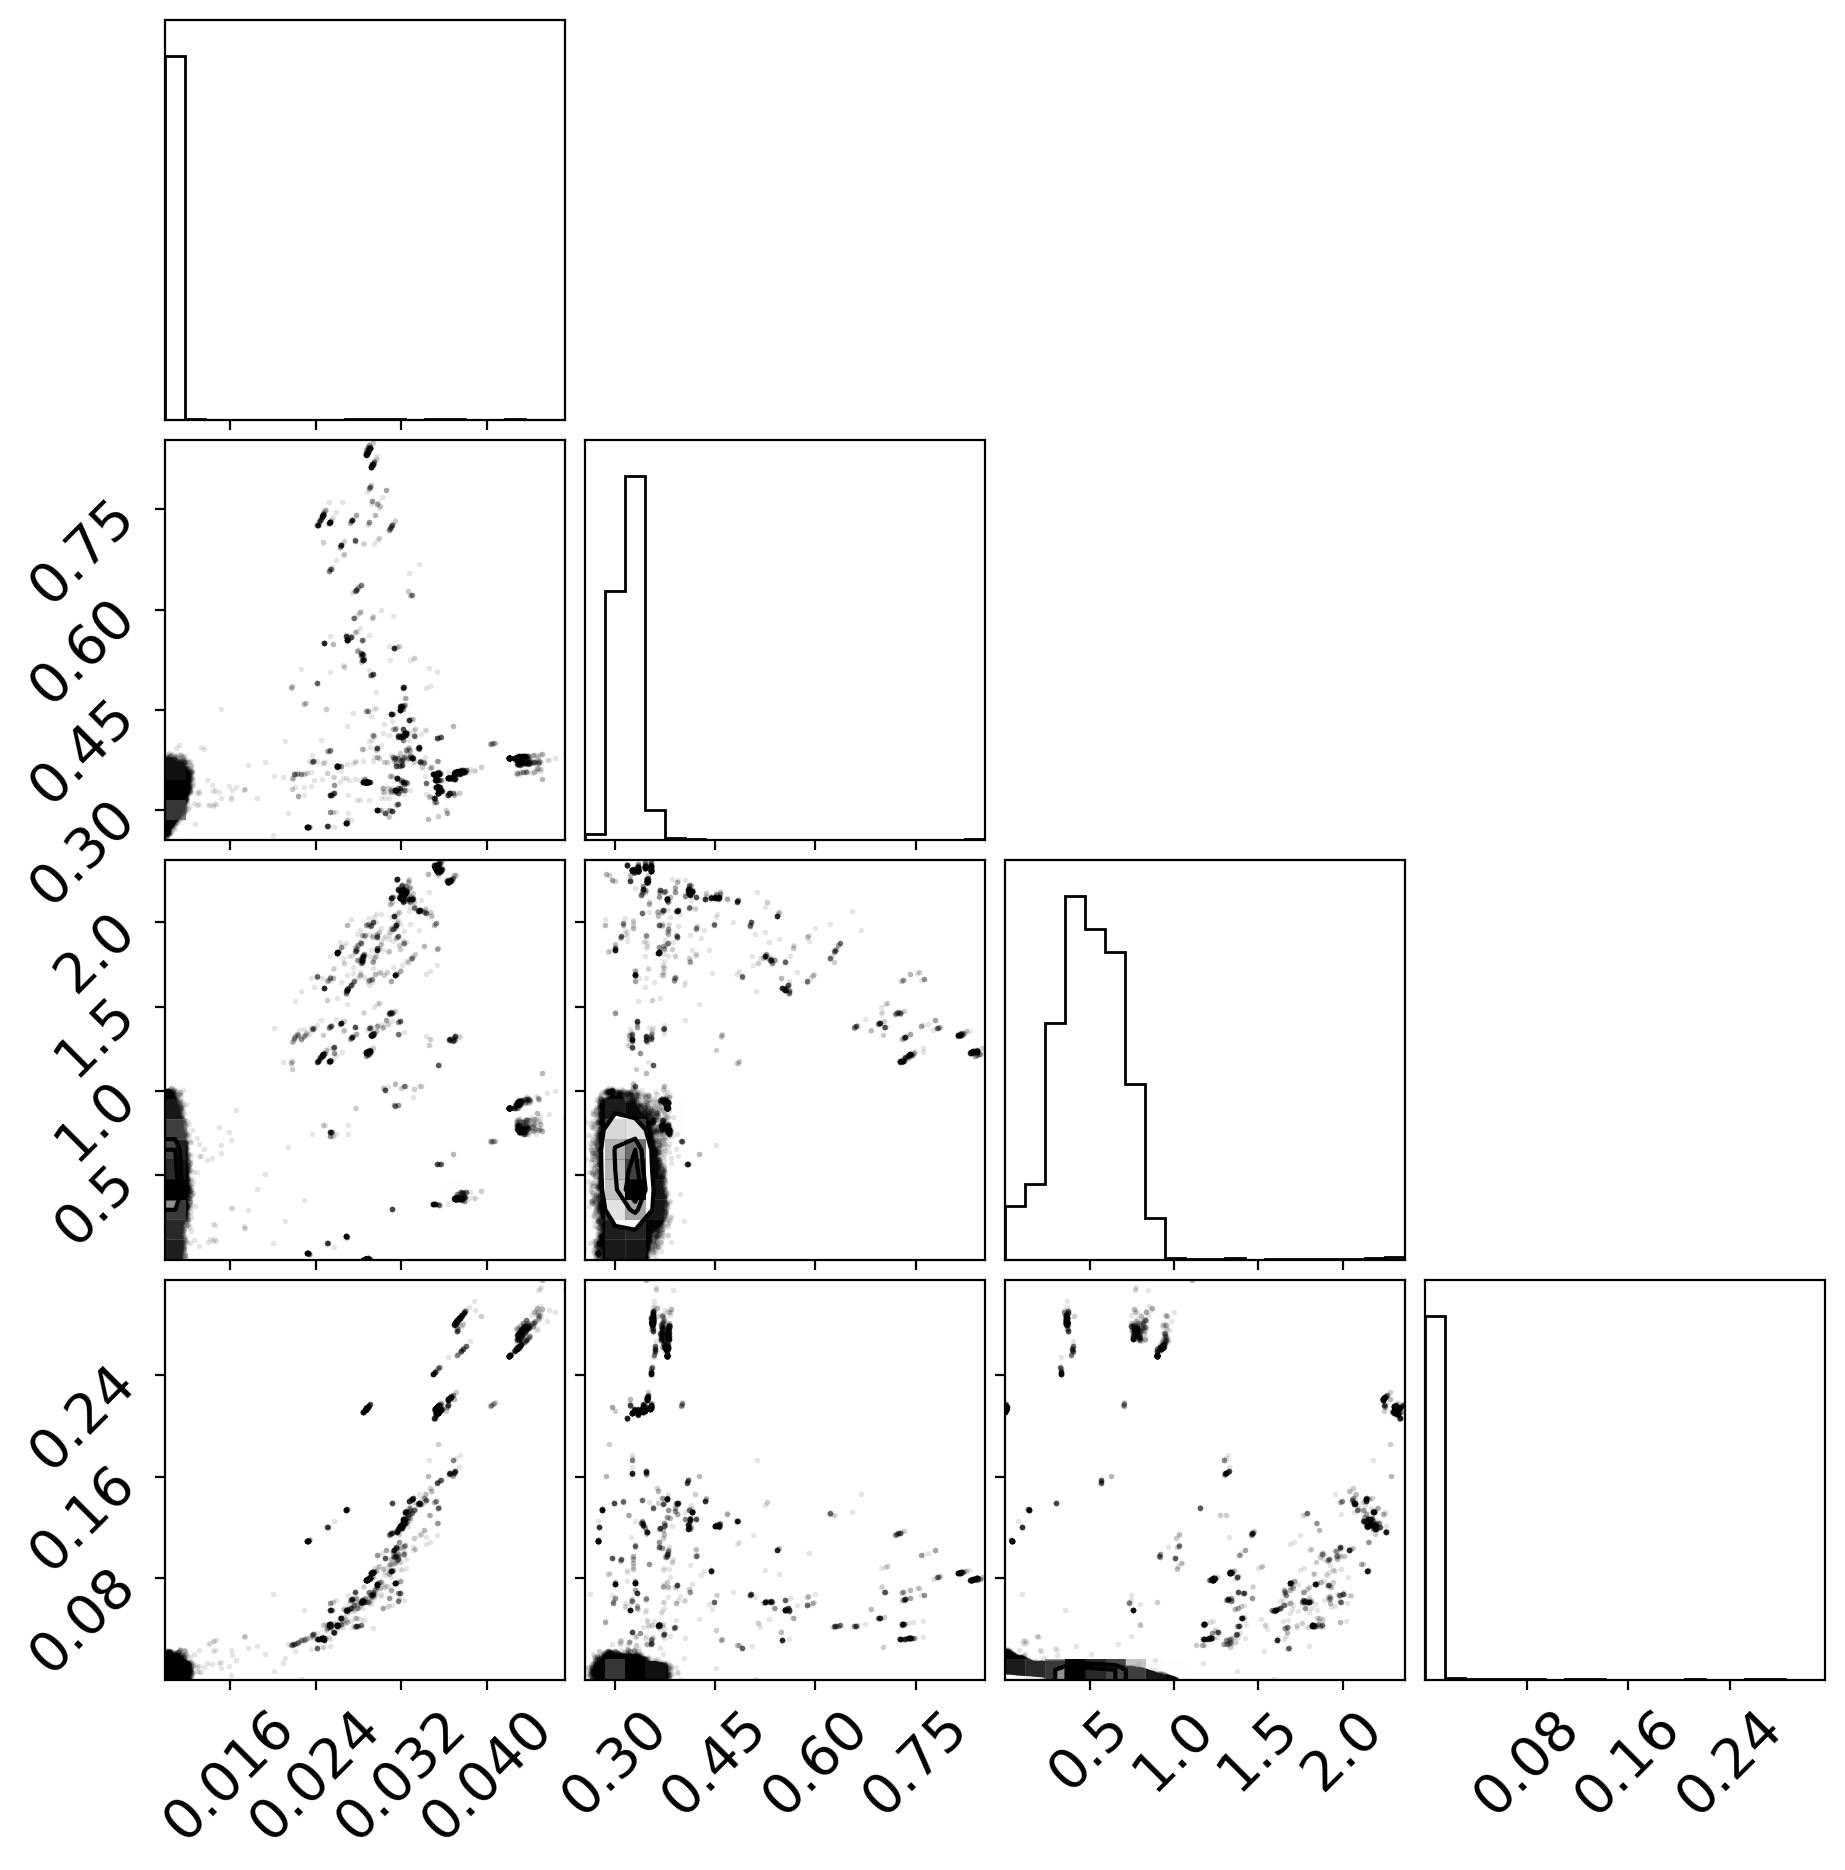

In [11]:
generate_plots(chain_name)

burnin = 268 thin = 37 tau = array([134.30770383,  74.53902332, 101.94636902, 102.09943427])


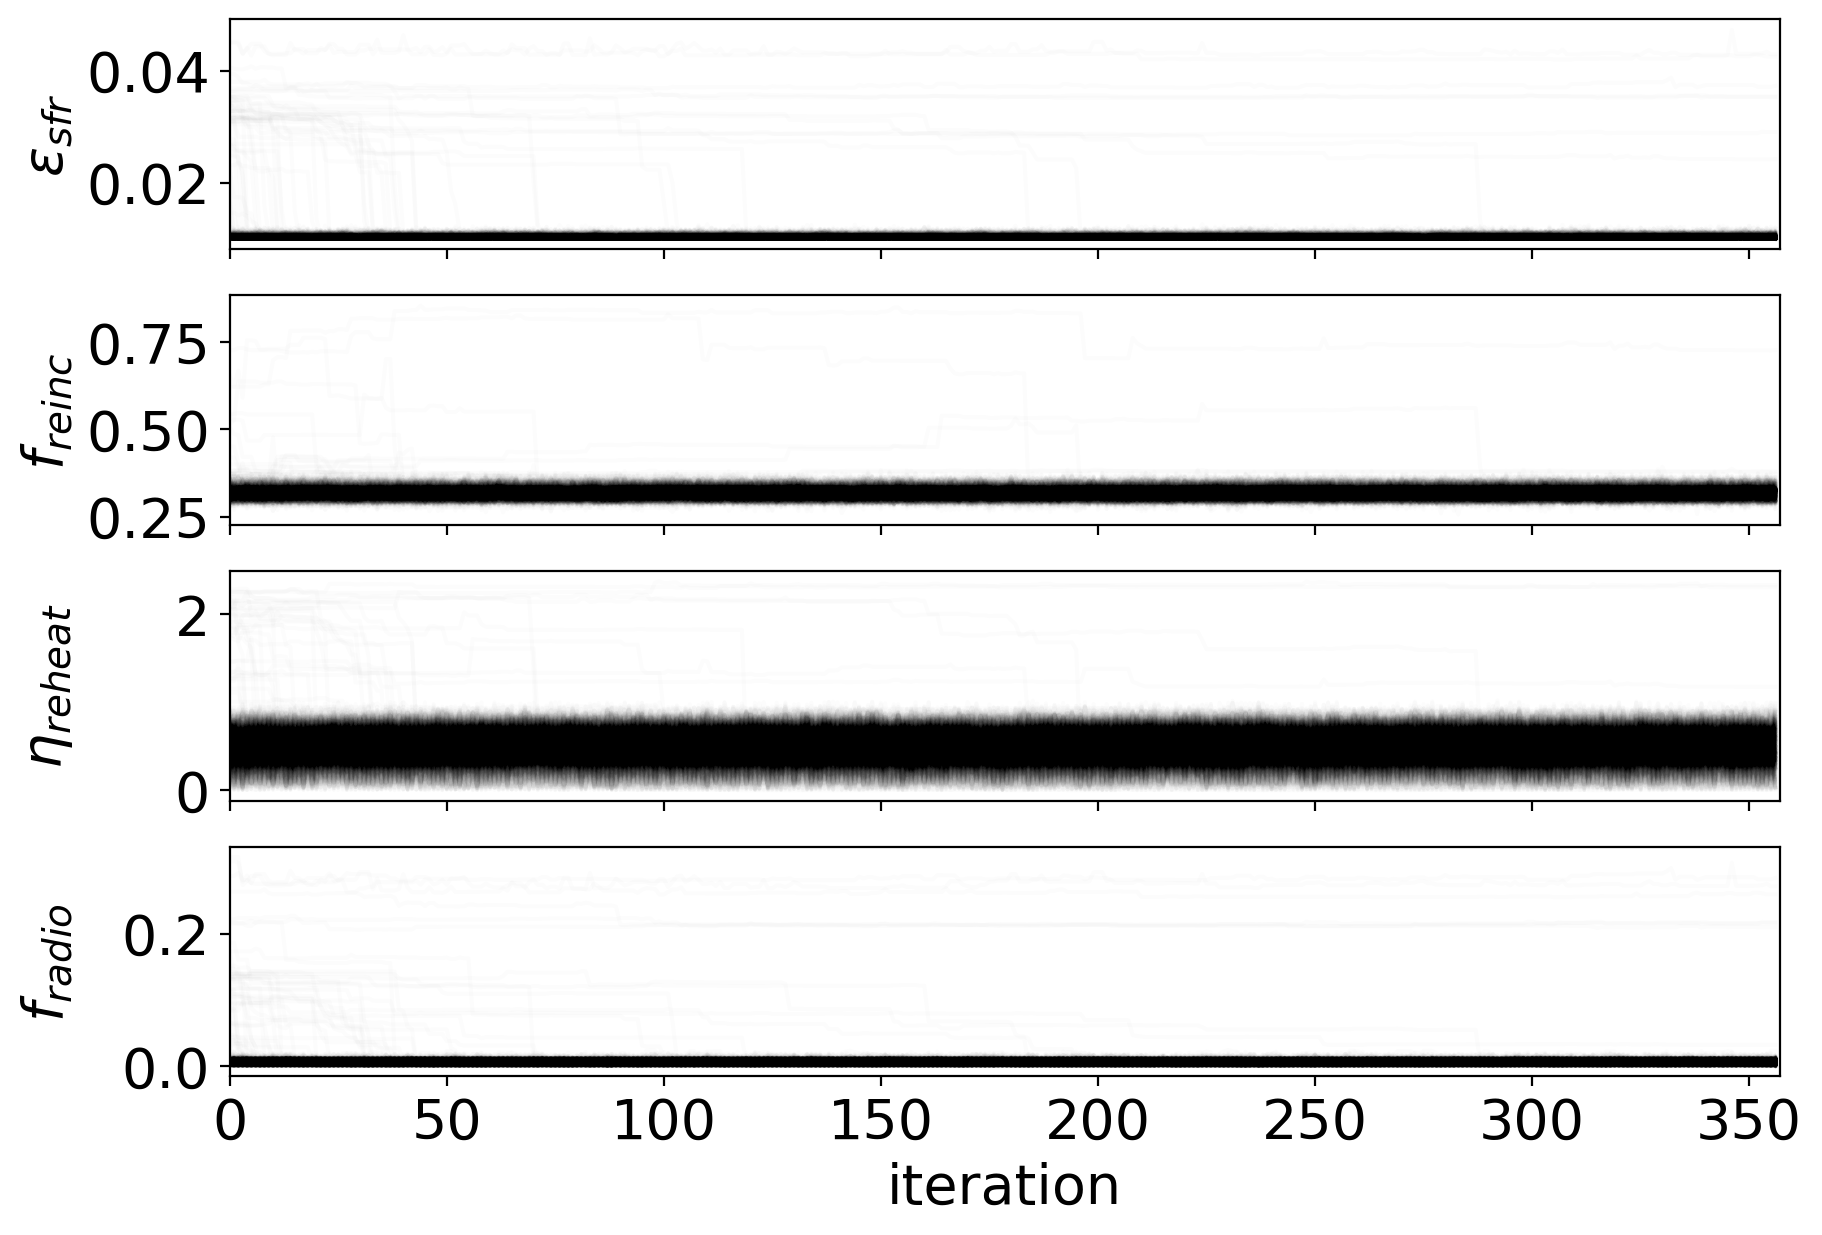

In [10]:
#plot_walkers(reader, sage_param_to_axis_labels(labels))

labels =['SfrEfficiency', 'ReIncorporationFactor', 'FeedbackReheatingEpsilon', 'RadioModeEfficiency']
truths = [0.05, 0.15, 3.0, 0.08]
burnin = 268 thin = 37 tau = array([134.30770383,  74.53902332, 101.94636902, 102.09943427])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

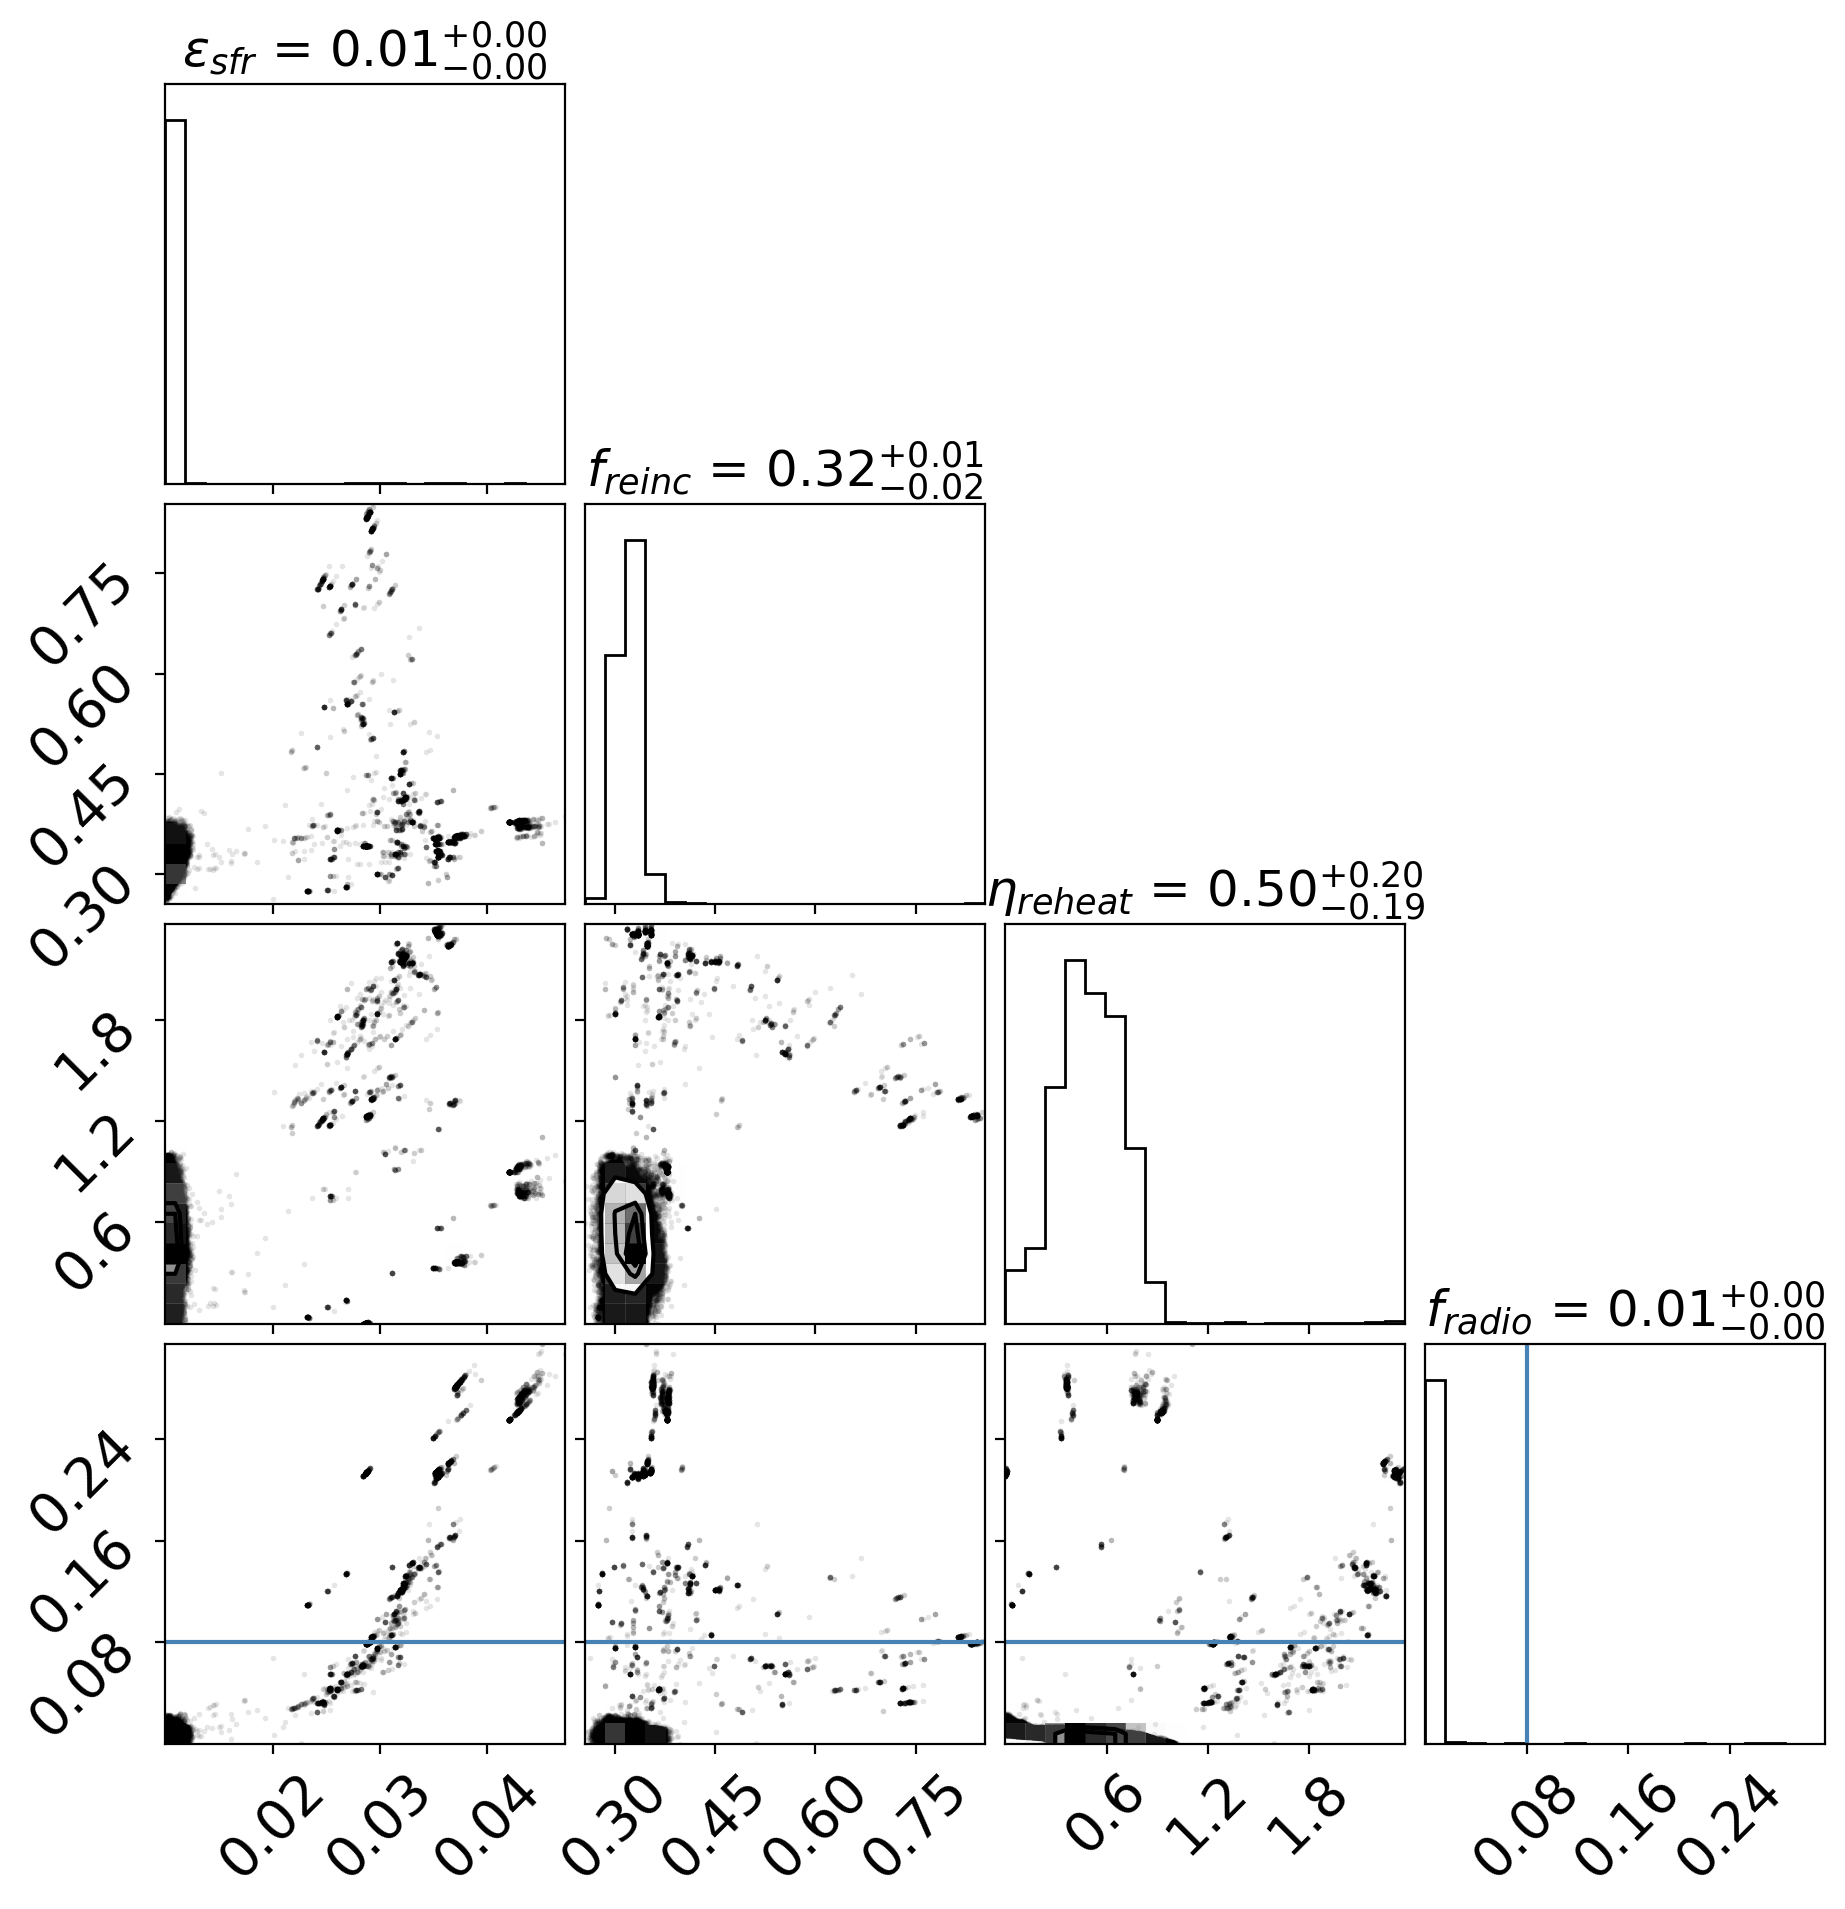

In [12]:
sage_fiducial_params = {'SfrEfficiency': 0.05,
                        'ReIncorporationFactor': 0.15,
                        'FeedbackReheatingEpsilon': 3.0,
                        'RadioModeEfficiency': 0.08
                        }

labels = get_labels_from_chain_name(chain_name)
name = get_name_from_chain_name(chain_name)
reader = emcee.backends.HDFBackend(chain_filename, name=name, read_only=True)
truths = [sage_fiducial_params[k] for k in labels]
print(f"{truths = }")
plot_contours_and_ci(reader, labels,
                     truths=truths,
                     show_titles=True,
                     label_kwargs={"fontsize":20}, title_kwargs={"fontsize": 18}, max_n_ticks=4)